# 시계열 분석 연습문제

## 문제 1 
이 데이터를 활용하여 조사기간동안 서울의 평균기온이 어떻게 변화하고 있는지 ARIMA와 AUTO_ARIMA를 사용하여 분석하고 앞으로 1년간의 평균 기온을 시각화 하시오.

시각화 기간은 2023년 8월 6일을 기준으로 전후 1년간으로 한다.

In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))


from datetime import datetime as dt
from datetime import timedelta
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import seaborn as sb
from helper import set_datetime_index, exp_timedata
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller



### #01. 데이터 불러오기 

In [2]:
df = pd.read_excel('https://data.hossam.kr/E06/temperatures_seoul.xlsx',index_col='날짜')
df.head()

,평균기온(℃)
날짜,
1973-07-01,22.7
1973-07-02,23.8
1973-07-03,27.2
1973-07-04,25.2
1973-07-05,26.9


### #02. 데이터 전처리



In [3]:
df.dtypes

평균기온(℃)    float64
dtype: object

In [4]:
df.isnull().sum()

평균기온(℃)    0
dtype: int64

In [5]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False

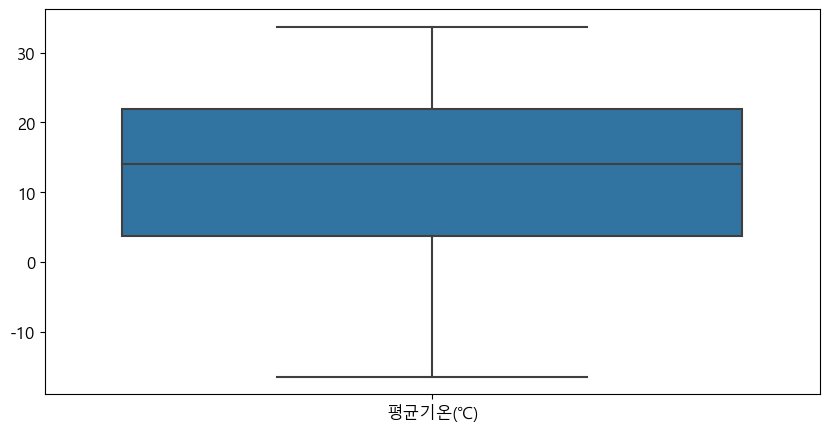

In [6]:
plt.figure()
sb.boxplot(data=df)
plt.show()
plt.close()

<Axes: xlabel='날짜'>

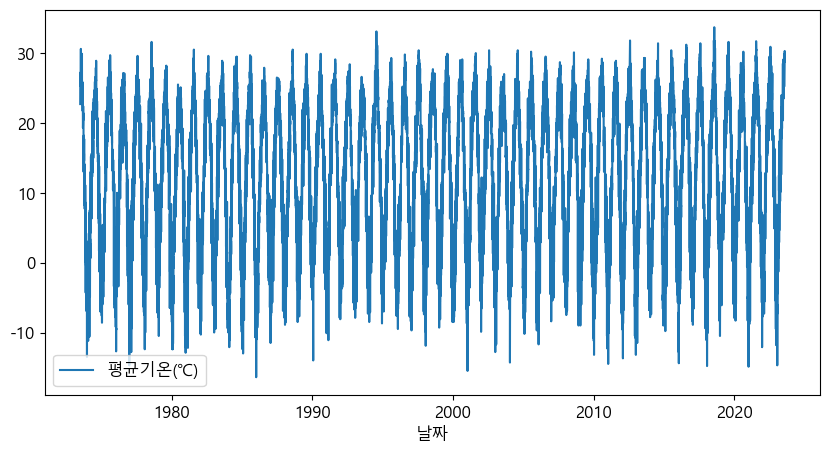

In [7]:
sb.lineplot(data=df)

### #03. 시계열 분해


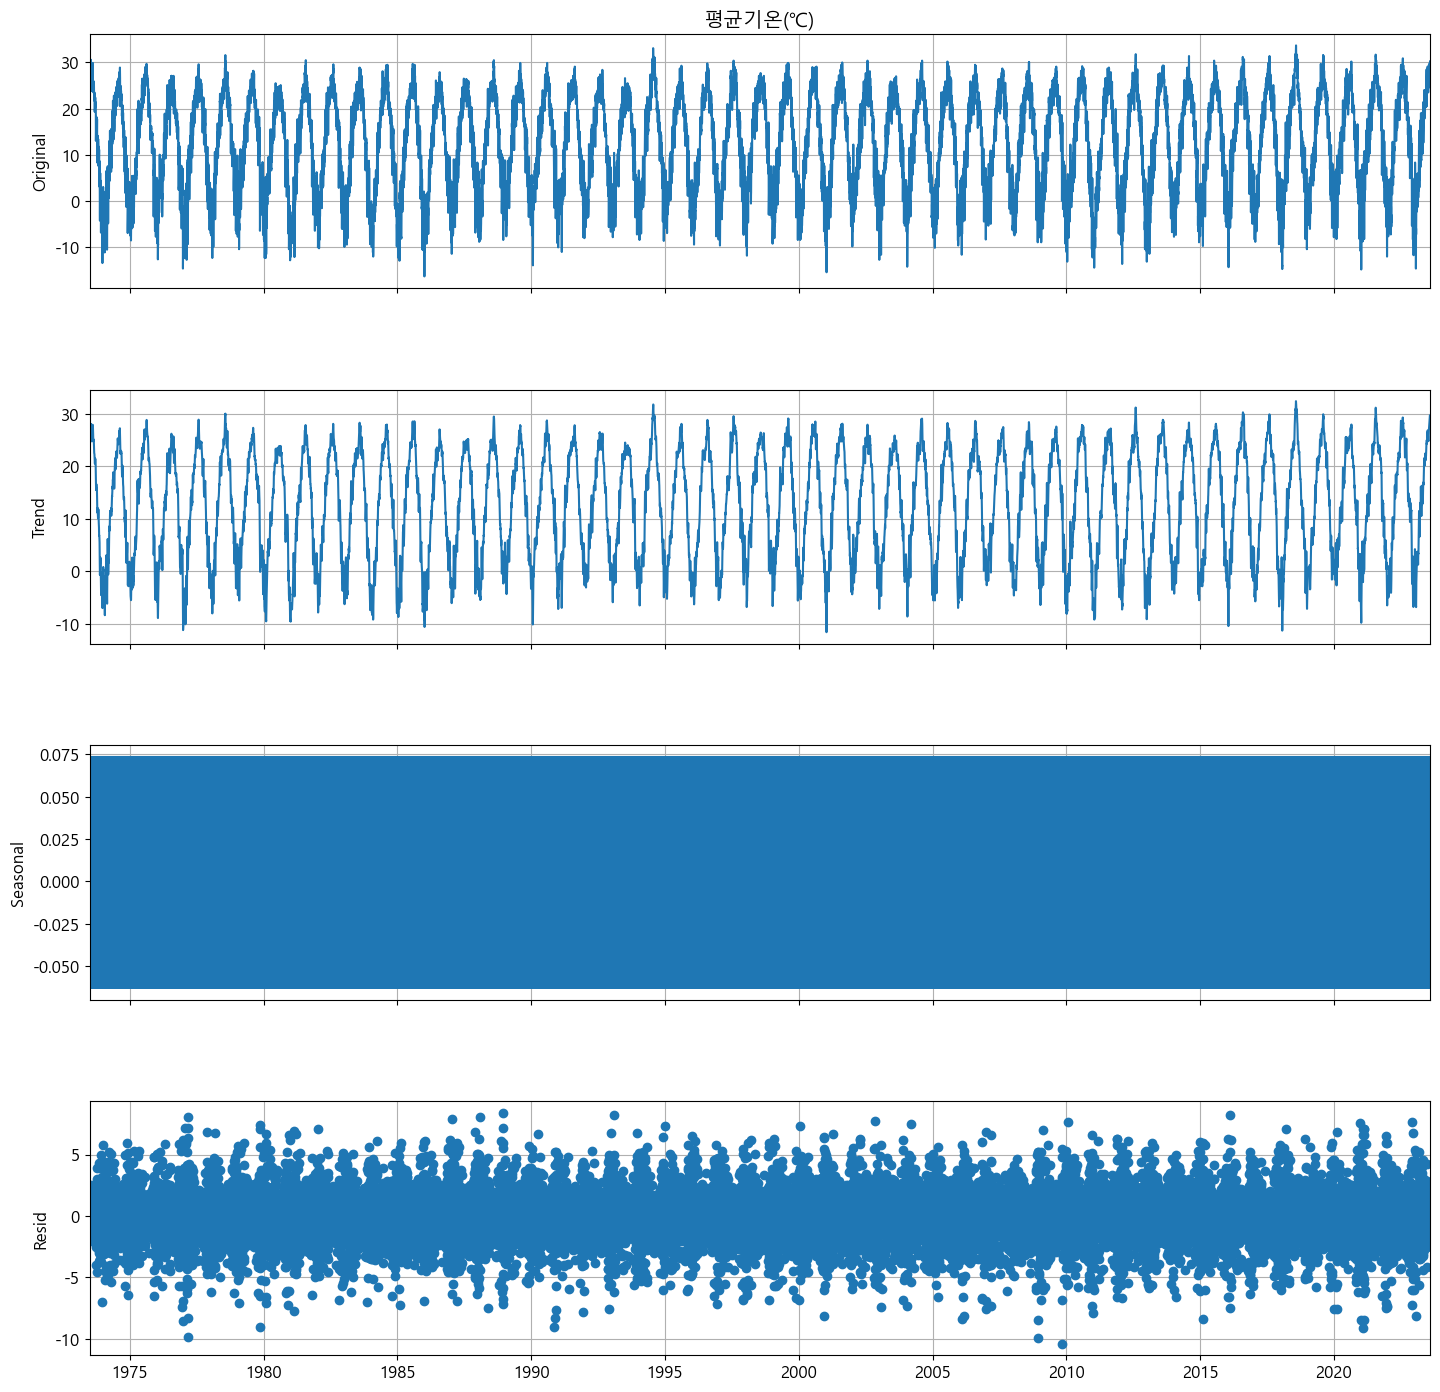

In [8]:
sd = seasonal_decompose(df['평균기온(℃)'],model = "additive")

figure = sd.plot()
figure.set_figwidth(15)
figure.set_figheight(16)
fig,ax1,ax2,ax3,ax4 = figure.get_children()
figure.subplots_adjust(hspace = 0.4)
ax1.set_ylabel("Original")
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
ax4.grid(True)



### #04. 정상성 여부 검정

In [9]:
ar = adfuller(df)
ardict = {
            '검정통계량 (ADF Statistic) ' : [ar[0]],
            'p-value ':[ar[1]],
            '최적 차수 ':[ar[2]],
            '관측치 개수':[ar[3]]
}
for key,value in ar[4].items() : 
    ardict['기각값 %s' % key] = value
        
stationality = ar[1]<0.05
ardict['데이터 정상성 여부(0=Flase,1=True)'] = stationality

ardf = pd.DataFrame(ardict,index = ['ADF']).T
ardf

,ADF
검정통계량 (ADF Statistic),-13.650422
p-value,0.0
최적 차수,45
관측치 개수,18253
기각값 1%,-3.430708
기각값 5%,-2.861698
기각값 10%,-2.566854
"데이터 정상성 여부(0=Flase,1=True)",True


In [10]:
df

,평균기온(℃)
날짜,
1973-07-01,22.7
1973-07-02,23.8
1973-07-03,27.2
1973-07-04,25.2
1973-07-05,26.9
...,...
2023-08-02,29.7
2023-08-03,29.5
2023-08-04,30.0


### #05. 모형결정 : ACF,PACF 테스트

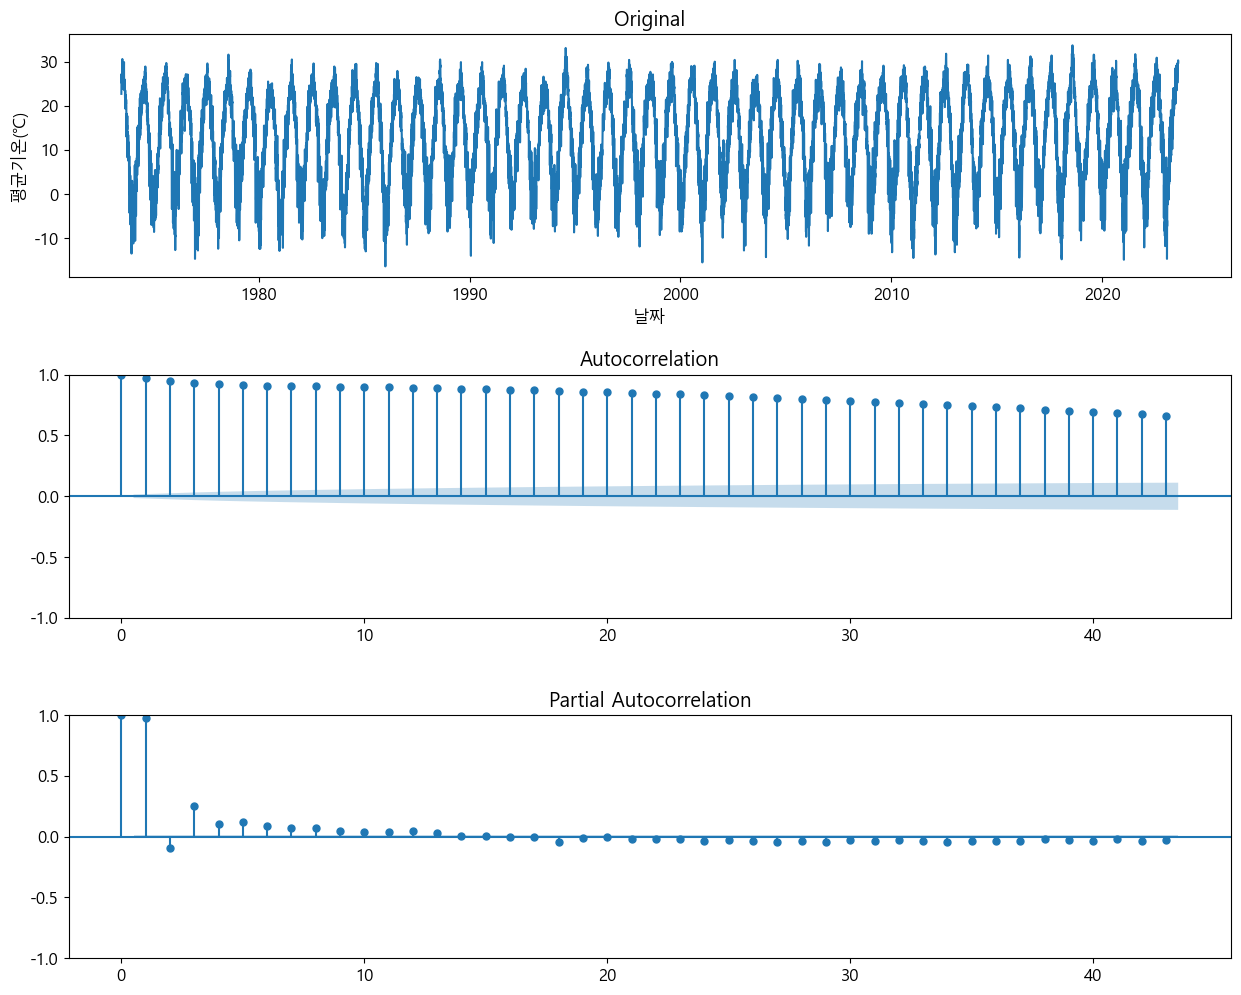

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
fig.subplots_adjust(hspace=0.4)

ax1.title.set_text("Original")
sb.lineplot(data=df, x=df.index, y='평균기온(℃)', ax=ax1)

ax2.title.set_text("ACF Test")
plot_acf(df['평균기온(℃)'], ax=ax2)
        
ax3.title.set_text("PACF Test")
plot_pacf(df['평균기온(℃)'], ax=ax3)
        
plt.show()
plt.close()

### #06. ARIMA
AR 모형 사용
p = 1
q= 0 
d= 0 


In [12]:
model = ARIMA(df['평균기온(℃)'],order = (1,0,0))
fit = model.fit()
print(fit.summary())

c:\Users\hamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\hamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\hamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                평균기온(℃)   No. Observations:                18299
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -41469.627
Date:                Mon, 07 Aug 2023   AIC                          82945.254
Time:                        13:57:13   BIC                          82968.698
Sample:                    07-01-1973   HQIC                         82952.957
                         - 08-06-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.6485      0.808     15.659      0.000      11.065      14.232
ar.L1          0.9748      0.002    543.691      0.000       0.971       0.978
sigma2         5.4434      0.043    127.064      0.0

In [13]:
fv = fit.fittedvalues
fv.head()

날짜
1973-07-01    12.648456
1973-07-02    22.446225
1973-07-03    23.518453
1973-07-04    26.832612
1973-07-05    24.883106
dtype: float64

In [14]:
fc = fit.forecast(365)
fc.head()

2023-08-07    29.366969
2023-08-08    28.944870
2023-08-09    28.533428
2023-08-10    28.132375
2023-08-11    27.741446
Freq: D, Name: predicted_mean, dtype: float64

In [15]:
df.tail()

,평균기온(℃)
날짜,
2023-08-02,29.7
2023-08-03,29.5
2023-08-04,30.0
2023-08-05,30.3
2023-08-06,29.8


#### 시각화



In [24]:
last = df.index.max()
xmin=last - timedelta(days=365)
xmax = last + timedelta(days = 365)
ymax = df['평균기온(℃)'][xmin:xmax].max()

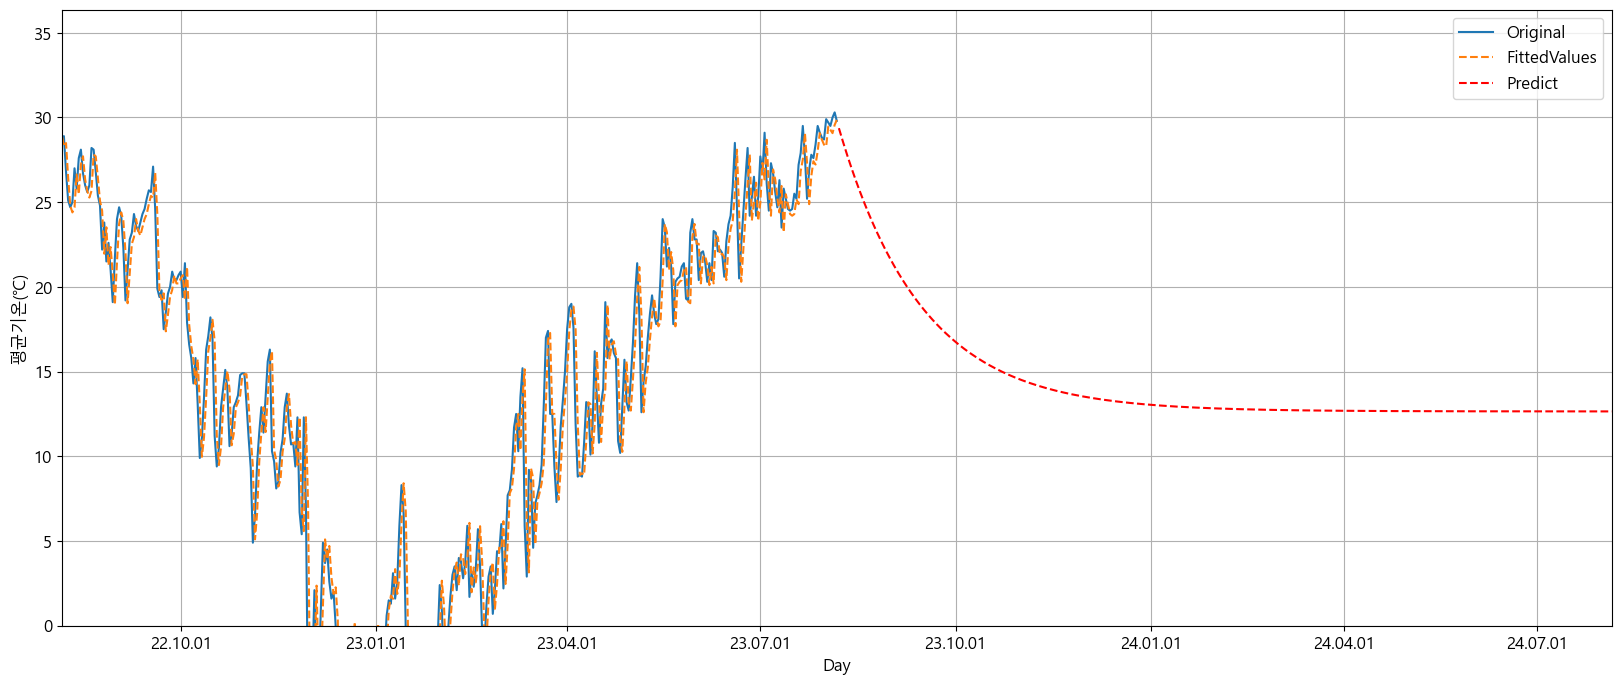

In [25]:
plt.figure(figsize=(20,8))

## 원본 데이터 
sb.lineplot(data=df,x=df.index , y='평균기온(℃)',label = 'Original')
## 원본에 대한 학습결과
sb.lineplot(x=fv.index,y=fv.values,label = 'FittedValues',linestyle = '--')
## 향후 120일 간의 예측치 
sb.lineplot(x=fc.index,y=fc.values,label = 'Predict', linestyle='--',color = 'red')

plt.xlabel('Day')
plt.ylabel('평균기온(℃)')
plt.legend()
plt.xlim([xmin, xmax])

plt.ylim([0, ymax*1.2])

## 그래프의 x축이 날짜로 구성되어 있을 경우 형식 지정
monthyearfmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearfmt)
plt.grid()
plt.show()
plt.close()

### #07. Auto ARIMA

In [28]:
my_p = 1    # AR의 차수 (검증한 결과를 활용)
my_d = 0    # 차분 횟수 (검증한 결과를 활용)
my_q = 0    # MA의 차수 (검증한 결과를 활용)
my_s = 0    # 계절성 주기 (분석가가 판단)

model = auto_arima(
    y=df['평균기온(℃)'],  # 모델링하려는 시계열 데이터 또는 배열
    start_p=0,           # p의 시작점
    max_p=my_p,          # p의 최대값
    d=my_d,              # 차분 횟수
    start_q=0,           # q의 시작점
    max_q=0,             # q의 최대값
    seasonal=True,       # 계절성 사용 여부
                         # 계절성 주기
    start_P=0,           # P의 시작점
    max_P=my_p,          # P의 최대값
    D=my_d,              # 계절성 차분 횟수
    start_Q=0,           # Q의 시작점
    max_Q=my_q,          # Q의 최대값
    trace=True           # 학습 과정 표시 여부
)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=137777.710, Time=0.38 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=82945.247, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=154307.360, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=83083.833, Time=0.42 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.586 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                18299
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -41469.624
Date:                Mon, 07 Aug 2023   AIC                          82945.247
Time:                        14:07:22   BIC                          82968.691
Sample:                    07-01-1973   HQIC                         82952.950
                         - 08-06-2023                                         
Covariance Type:                  opg                    

In [29]:
fv = model.fittedvalues()
fv.head()
fc = model.predict(365)


In [32]:
last = df.index.max()
xmin = last - timedelta(days=365)
xmax = last + timedelta(days=365)
ymax = df['평균기온(℃)'][xmin:xmax].max()


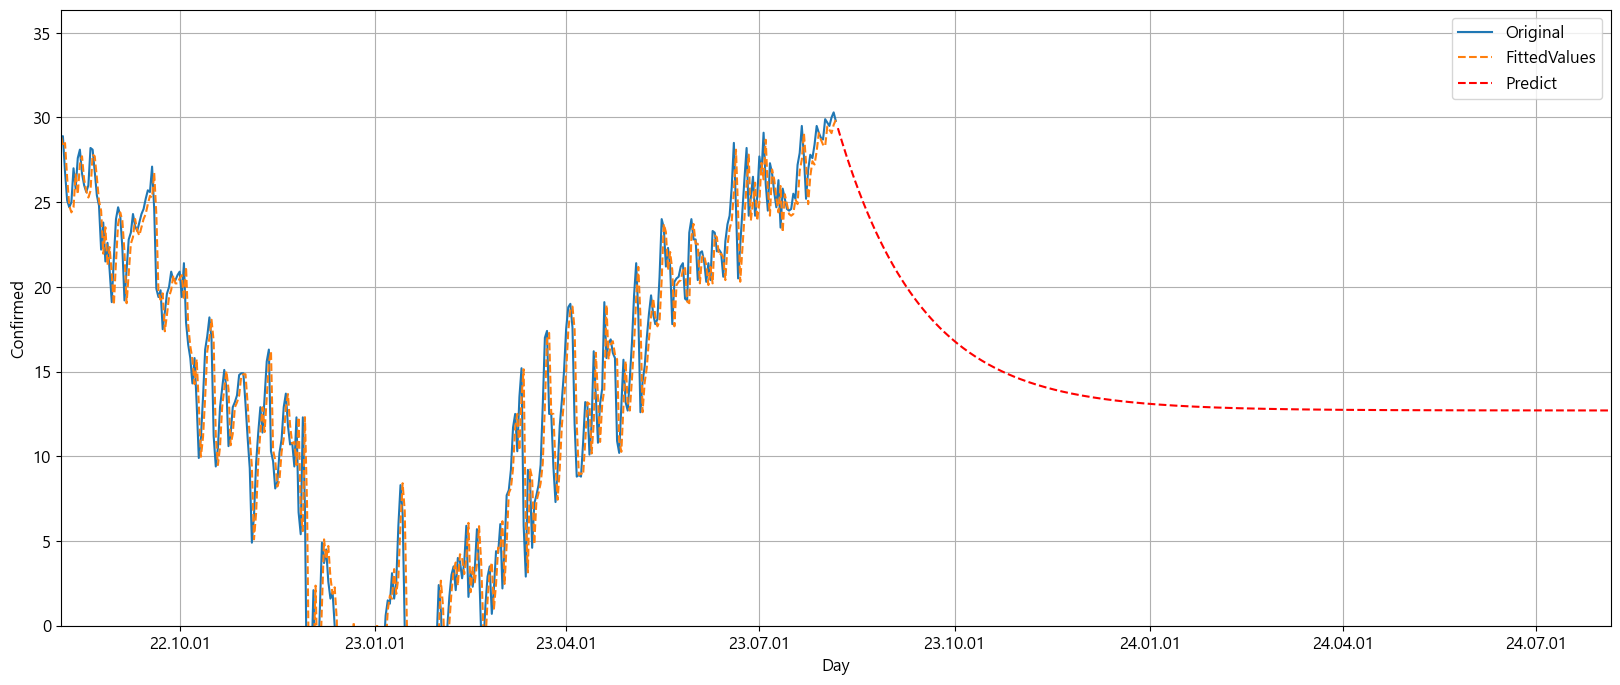

In [33]:
plt.figure(figsize=(20,8))

# 원본데이터
sb.lineplot(data=df,x=df.index,y='평균기온(℃)',label = 'Original')

## 원본에 대한 학습결과
# 원본에 대한 학습결과
sb.lineplot(x=fv.index, y=fv.values, label='FittedValues', linestyle='--')

# 향후 120일간의 예측값
sb.lineplot(x=fc.index, y=fc.values, label='Predict', linestyle='--', color='red')

plt.xlabel('Day')
plt.ylabel('Confirmed')
plt.legend()

plt.xlim([xmin, xmax])
plt.ylim([0, ymax*1.2])

# 그래프의 x축이 날짜로 구성되어 있을 경우 형식 지정
monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()